## Импорт библиотек

In [1]:
# Бибилиотеки для работы с данными
# ==============================================================================
import pandas as pd
import numpy as np

# Игнорирует все предупреждения
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Визуализация
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Метрики для оценки работы модели
# ==============================================================================
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

# Разделение данных, кросс валидация и подбор гиперпараметров
# ==============================================================================
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Процессинг данных
# ==============================================================================
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Создание объекта для стандартизации

# Модели машинного обучения
# =============================================================================
import statsmodels.api as sm # Для построения линейной регрессии
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# Tracking MLFLow
# =============================================================================
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

## Настройка параметров графика

In [2]:
# Настройка параметров графика
# ==============================================================================
params = {'figure.figsize' : (12,8),
          'axes.titlesize' : 16,
          'axes.titleweight' : 'bold'}

# Обновление параметров для графиков 
# ==============================================================================
plt.rcParams.update(params)

## Просмотр данных 

Загружаем набор данных который мы преобразовали (поработали с пропусками и с типами данных) о ценах на недвижимость в москве и московской области

In [3]:
df = pd.read_csv('Цены на недвижимость без пропусков.csv')
df.head(3)

,Цена,Тип квартиры,Станция метро,Минут до метро,Регион,Адрес,Количество комнат,Площадь,Жилая площадь,Кухня площадь,Этаж,Количество этажей,Ремонт,Ссылка
0,6300000.0,Вторичное,Опалиха,6.0,Московская область,Московская Красногорский район Красногорск Изу...,1.0,30.6,11.1,8.5,25.0,25,Косметический,https://www.cian.ru/sale/flat/289238903
1,9000000.0,Вторичное,Павшино,2.0,Московская область,Московская Красногорский район Красногорск Иль...,1.0,49.2,20.0,10.0,6.0,15,Евроремонт,https://www.cian.ru/sale/flat/292849723
2,11090000.0,Вторичное,Мякинино,14.0,Московская область,Московская Красногорский район Красногорск бул...,1.0,44.7,16.2,13.1,10.0,25,Косметический,https://www.cian.ru/sale/flat/290714580


Посмотрим информацию о признаках, чтобы понять с какими мы столбцами будем работать, какие типы данных существуют в нашем наборе данных, сколько уникальных значений (это нам поможет поноять как кодировать категориальные признаки в дальнейшем, при подготовке данных к моделе предсказания), посомтрим количество данных, которое у нас есть, а так же процент непропущенных значений (но так как мы заполнили все значения `NaN`, то в данных не должно быть значений `NaN`

Так же создадим функцию, которая окрашивает категориальные данные в синий цвет, а тип данных число - в красный цвет (это сделано для удобства восприятия)

In [4]:
# Функция для стилизации ячеек
def color_cells(val):
    """ val: значение признака """
    
    if val == 'float64':
        color = 'red'   # цвет для float
    elif val == 'int64':
        color = 'red' # цвет для int
    else:
        color = 'blue' # цвет для object
    return f'color: {color}'

In [5]:
info = pd.DataFrame()
info.index = df.columns
info['Тип данных'] = df.dtypes
info['Колчесвто уникальных'] = df.nunique()
info['Количество пропусков'] = df.isna().sum()
info['Количество значений'] = df.count()
info['%значений'] = round((df.count()/ df.shape[0]) * 100,2)

# Применение стилизации только к столбцу Тип данных
info = info.style.applymap(color_cells, subset=['Тип данных'])

# Информация о признаках (столбцах)
# ==============================================================================
info

,Тип данных,Колчесвто уникальных,Количество пропусков,Количество значений,%значений
Цена,float64,9979,0,22676,100.000000
Тип квартиры,object,2,0,22676,100.000000
Станция метро,object,547,0,22676,100.000000
Минут до метро,float64,56,0,22676,100.000000
Регион,object,2,0,22676,100.000000
Адрес,object,6386,0,22676,100.000000
Количество комнат,float64,12,0,22676,100.000000
Площадь,float64,3017,0,22676,100.000000
Жилая площадь,float64,1302,0,22676,100.000000
Кухня площадь,float64,481,0,22676,100.000000


**Проанализировав данную сводную таблицу сделаем несколько выводов про набор данных:**

1. Мы имеем данное соотношение типо данных - `8 numbers` / `6 objects`, то есть в нашем наборе преобладают числовые значения.
2. Количество значений = 22676 и в каждом признаке 100% заполненных значений
3. Нет пропусков (значений `NaN` в наборе данных)
4. Признак `Цена` очень вариативный, так как содержит 9979 уникальных значений (так же обратно можно сделать вывод, что есть цены на квартиры, которые повторяются)
5. Уникальных значений в столбце `Ссылка` - 21813, а ссылки на дома - это уникальные значения. Следовательно стоит обратить внимание, что есть повторяющиеся ссылки, а следовательно повторяющиеся объявления в данных (дубликаты), которые надо удалить до работы с данными


Следовательно далььше мы и сделаем удаление дубликатов по столбцу `Ссылка` 
После удаления дубликатов, у нас должен остаться набор, с количеством наблюдений = 21813

In [6]:
# Удаление дубликатов по столбцу Сслыка
df = df.drop_duplicates(subset="Ссылка")

# Проверка (размер = 21813) и вывод набора дыннх
print(df.shape)
df.head(3)

(21813, 14)


,Цена,Тип квартиры,Станция метро,Минут до метро,Регион,Адрес,Количество комнат,Площадь,Жилая площадь,Кухня площадь,Этаж,Количество этажей,Ремонт,Ссылка
0,6300000.0,Вторичное,Опалиха,6.0,Московская область,Московская Красногорский район Красногорск Изу...,1.0,30.6,11.1,8.5,25.0,25,Косметический,https://www.cian.ru/sale/flat/289238903
1,9000000.0,Вторичное,Павшино,2.0,Московская область,Московская Красногорский район Красногорск Иль...,1.0,49.2,20.0,10.0,6.0,15,Евроремонт,https://www.cian.ru/sale/flat/292849723
2,11090000.0,Вторичное,Мякинино,14.0,Московская область,Московская Красногорский район Красногорск бул...,1.0,44.7,16.2,13.1,10.0,25,Косметический,https://www.cian.ru/sale/flat/290714580


После преобразования мы проверили размер и размер сошелся, следовательно мы удалили все дубликаты в данных.

Далее построим новую таблицу для просмотра описательной статистики

**Выводы описательной статистики:**
1. Срденее значение цены квартиры 32 878 966.67
2. Минимальная цена дома 1 150 000
3. Максимальная цена дома 2 455 020 000
4. Между 75% и максимальным значением цены - очень большой диапазон знчений, что свидетельствует о наличии аномальных значений
5. Так же на это указывает значение std, которое равно 77 996 296.24, что означает очень большой разброс значений вокруг среднего
6. Так же есть аномальные значения в признаках `Минут дло метро`, `Количество комнат`, `Жилая площадь` и все остальные числовые признаки в модели

Данные аномалии не являются ошибками в данных, это просто значения дорогих квартир, для того чтобы принять решение о том, что делать с аномальными значениями - проведем дальнейший анализ

In [7]:
describe = df.describe().T
describe['mean'] = describe['mean'].apply(lambda x: '{:.2f}'.format(x))
describe['std'] = describe['std'].apply(lambda x: '{:.2f}'.format(x))
describe['max'] = describe['max'].apply(lambda x: '{:.2f}'.format(x))
describe['count'] =describe['count'].astype('int')

# Описательная статистика для набора данных
# ==============================================================================
describe

,count,mean,std,min,25%,50%,75%,max
Цена,21813,32878966.67,77996296.24,1150000.0,6998445.00,11086692.0,22383687.00,2455020000.00
Минут до метро,21813,11.98,6.21,0.0,7.00,12.0,15.00,60.00
Количество комнат,21813,2.01,1.47,0.0,1.00,2.0,3.00,12.00
Площадь,21813,68.76,62.99,6.0,37.16,52.4,74.65,1117.00
Жилая площадь,21813,37.00,35.31,2.0,17.50,28.1,42.00,566.80
Кухня площадь,21813,12.34,7.39,1.0,8.60,10.5,14.00,122.00
Этаж,21813,9.17,7.40,1.0,4.00,8.0,13.00,92.00
Количество этажей,21813,16.51,9.42,1.0,11.00,16.0,20.00,97.00


Для визуализации мы построим матрицу графиков для признака `Цена`, чтобы посмотреть распредление и структуру данных в признаке 

**Выводы по визуализации:**
1. Как и в описательной статистике, видно что большинство значний расположено в белой зоне
2. Небольшая площадь белой зоны указывает что значения цены распределены преимущественно на небольшом диапазоне
3. Красная зона (она визуализирована в значении матрицы 2,2 - 2 строка, 2 график). Там показано распредление количества квартир с определенными ценами, то есть сделан Zoom на график.
4. По графику `Распределение непопулярных значений` можно сделать вывод, что чем дороже квартира, тем меньше их в наборе данных)
5. Так же график `Диаграмма ящика` показывает нам на то, что в данных есть выбросы и их количество

Все эти графики отражают структуру целевого признака `Цена`, для которого мы будем делать предсказание
Здесь построены разные виды графиков, но все они отржают одну суть - просмотр и выявление структуры и аномальных значений в признаке `Цена`

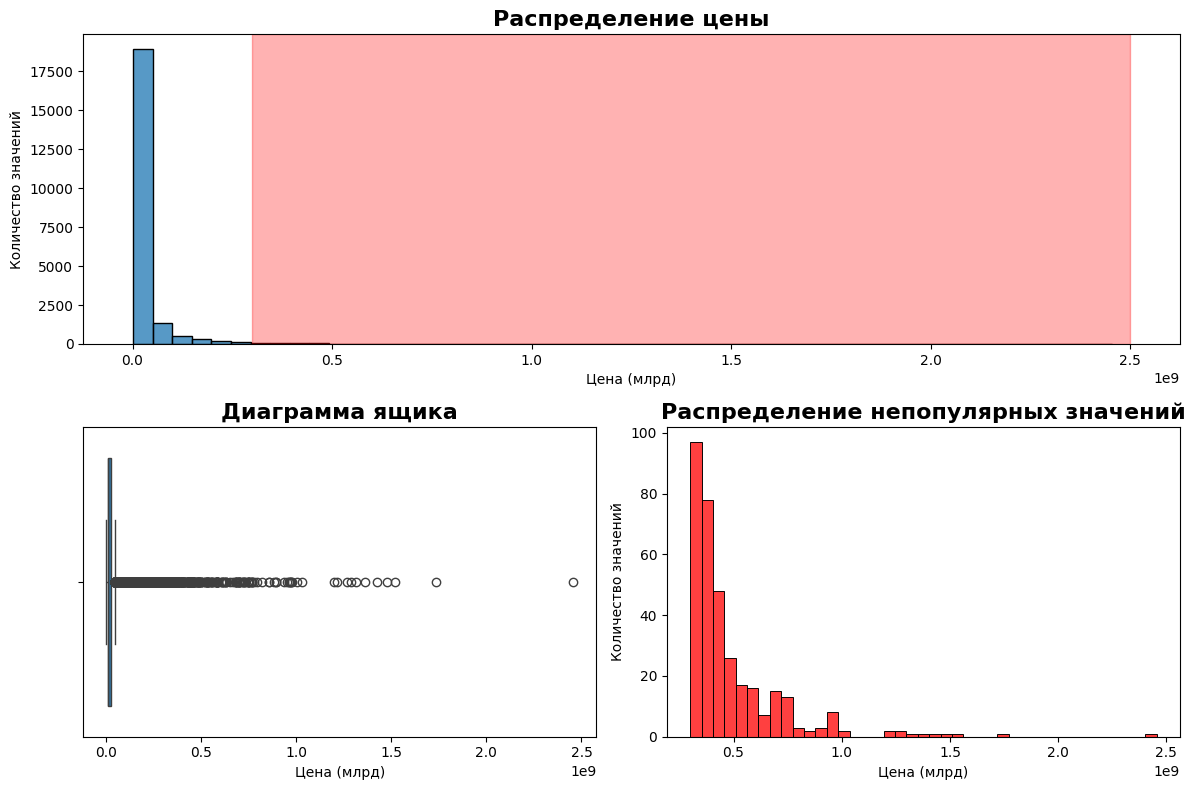

In [8]:
# Первый график - Распределение цены (гистограмма)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan = 2) # 1 значение - размер сетки подграфика, 2 значение - положение подграфика, colspan - растянутость 
sns.histplot(data = df,
             x = 'Цена',
             bins = 50,
             ax = ax1)
# Выделение диапазона от 80 до 100
ax1.axvspan(0.3e9, 2.5e9, color='red', alpha=0.3)
ax1.set_title('Распределение цены')
ax1.set_xlabel('Цена (млрд)')
ax1.set_ylabel('Количество значений')



# Второй график - Диаграмма ящика с усами
ax2 = plt.subplot2grid((2, 2), (1, 0))
sns.boxplot(data = df, x = 'Цена', ax = ax2)
ax2.set_title('Диаграмма ящика')
ax2.set_xlabel('Цена (млрд)')



# третий график - Значения цены, которые больше 300 000000 
unpopular = df[df['Цена'] >= 0.3 * 10**9]
# Визуализация распределения значений > 300 000000
ax3 = plt.subplot2grid((2, 2), (1, 1))
sns.histplot(data = unpopular,
             x = 'Цена',
             ax = ax3,
            color = 'red')
ax3.set_title('Распределение непопулярных значений')
ax3.set_xlabel('Цена (млрд)')
ax3.set_ylabel('Количество значений')

# Комплексная визуализация целевого признака 
# ==============================================================================
plt.tight_layout()
plt.show()

Так же построим такой же график по площади (так как цена и площадь - это ключевые показатели в наборе данных)

**Выводы по визуализации площади и взаимосвязи переменных:**
1. Значения площади (так же как и значения цен на квартиры) распложены преимущественно в диапазоне от 0 до 100
2. Так же можно заметить что есть аномальные значения (то есть площадь квартир, которые больше 100)
3. Взаимосвязь между признаками `Цена` и  `Площадь` = 0.79, то есть медлу признаками существет линейная зависимоть (можно описать формулой)

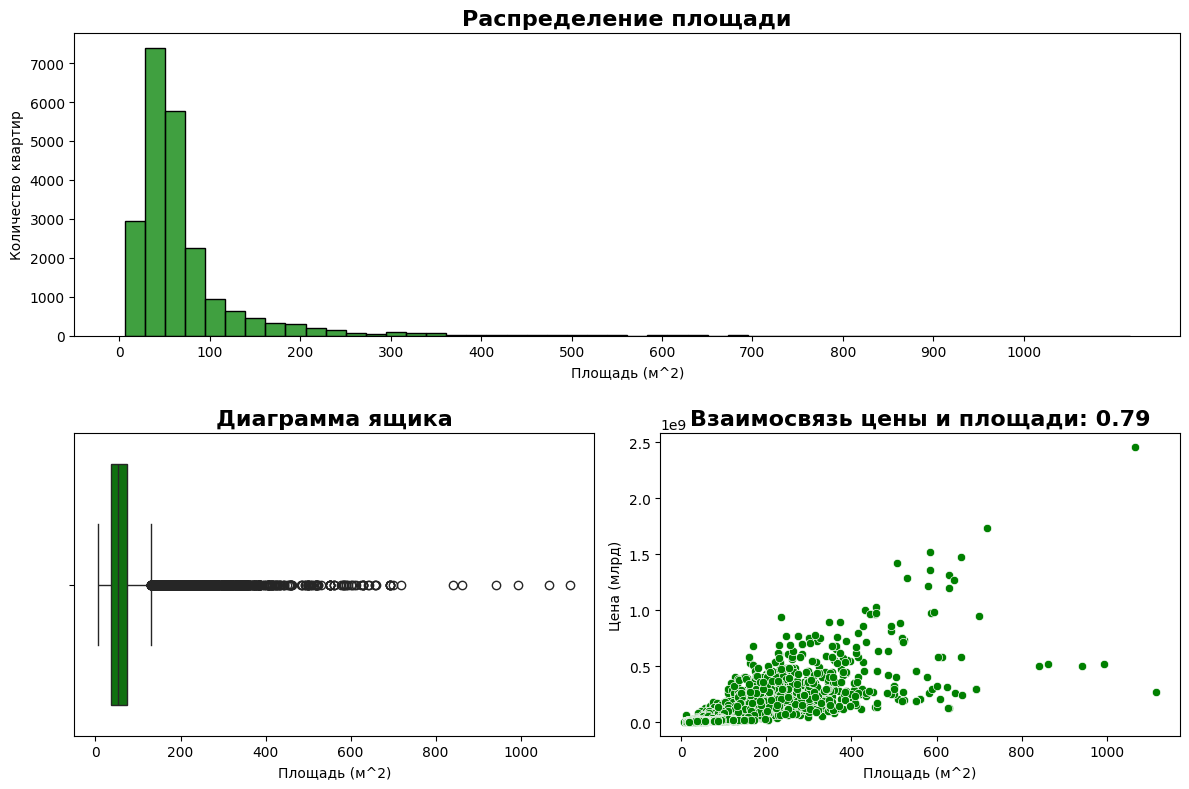

In [9]:
# График 1 - распределение площади
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan = 2) 
sns.histplot(data = df,
             x = 'Площадь',
             bins = 50,
             ax = ax1,
             color = 'g')
ax1.set_title('Распределение площади')
ax1.set_ylabel('Количество квартир')
ax1.set_xlabel('Площадь (м^2)')
ax1.set_xticks(range(0,1001,100))

# График 2 - Диаграмма ящик с усами
ax2 = plt.subplot2grid((2, 2), (1, 0))
sns.boxplot(data = df, x = 'Площадь', ax = ax2, color = 'g')
ax2.set_title('Диаграмма ящика')
ax2.set_xlabel('Площадь (м^2)')

# График 3 - Точечная диаграмма взаимосвязи между ценой и площадью
ax3 = plt.subplot2grid((2, 2), (1, 1))
sns.scatterplot(data = df,
                x = 'Площадь',
                y = 'Цена',
                ax = ax3,
                color = 'g')
# Корреляция между ценой и площадью
corelation = round(df[['Площадь', 'Цена']].corr()['Цена'].loc['Площадь'],2)
ax3.set_title(f'Взаимосвязь цены и площади: {corelation}')
ax3.set_xlabel('Площадь (м^2)')
ax3.set_ylabel('Цена (млрд)')


# Комплексная визуализация признака площадь и взаимосвязь между площадью и целевым значением  
# ==========================================================================================
plt.tight_layout()
plt.show()

После визуализации двх признаков (`Цена` и `Площадь`) и просмотра описательной статистики можно сказать, что так как во всех признаках есть аномальные значени (то есть значения которые выбиваются из большинства значений) то скорее всего все эти аномальные значения как раз и связаны с высокой ценой квартиры

Мы проверим эту гипотизу, чтобы точно ответить на вопрос, правда это или нет

**Что сделали чтобы проверить гипотезу**: Посчитали количество аномальных значений (которые идут после 75%) по каждой переменной

**Выводы по гипотезе**
1. Количество аномальных значений по каждому признаку примерно равно (единственное значение которое выбивается - количество комнат и количество этажей)

Следовательно скорее всего это такая природа данных, то есть аномальные значения - это не ошибки, и пока будем работать с полным набором данных (то есть не будем делать никаких преобразований с выбросами)
После построения моделей машинного обучения поэксперементируем с выбросами и выберем исход, который использовать при выборе финальной модели

In [10]:
#  Набор данных для записи количества аномальных значений
number_extreme = pd.DataFrame()
# Список для передачи в индекс
list_index = []
# Список для передачи значений
list_values = []

for i in describe.index:
    """
    Создается порог (doorstep) для того чтобы создать набор с аномальными значениям (set)
    Внутри определяется описательная статистика (describe) и записывается только признак и количество значений (count) по каждому 
    признаку в цикле (describe.index - все числовые признаки)
    """
    
    doorstep = describe['75%'].loc[i]
    set = df[df[i] > doorstep]
    set = set.describe().T
    list_index.append(i)
    list_values.append(set['count'].loc[i])

number_extreme.index = list_index
number_extreme['Количество экстремальных значений'] = list_values
number_extreme

,Количество экстремальных значений
Цена,5453.0
Минут до метро,5276.0
Количество комнат,3230.0
Площадь,5452.0
Жилая площадь,5428.0
Кухня площадь,5452.0
Этаж,5046.0
Количество этажей,4020.0


Далее визуализируем взаимосвязь между признаками и посмотрим мультиколлинеарность среди числовых признаков

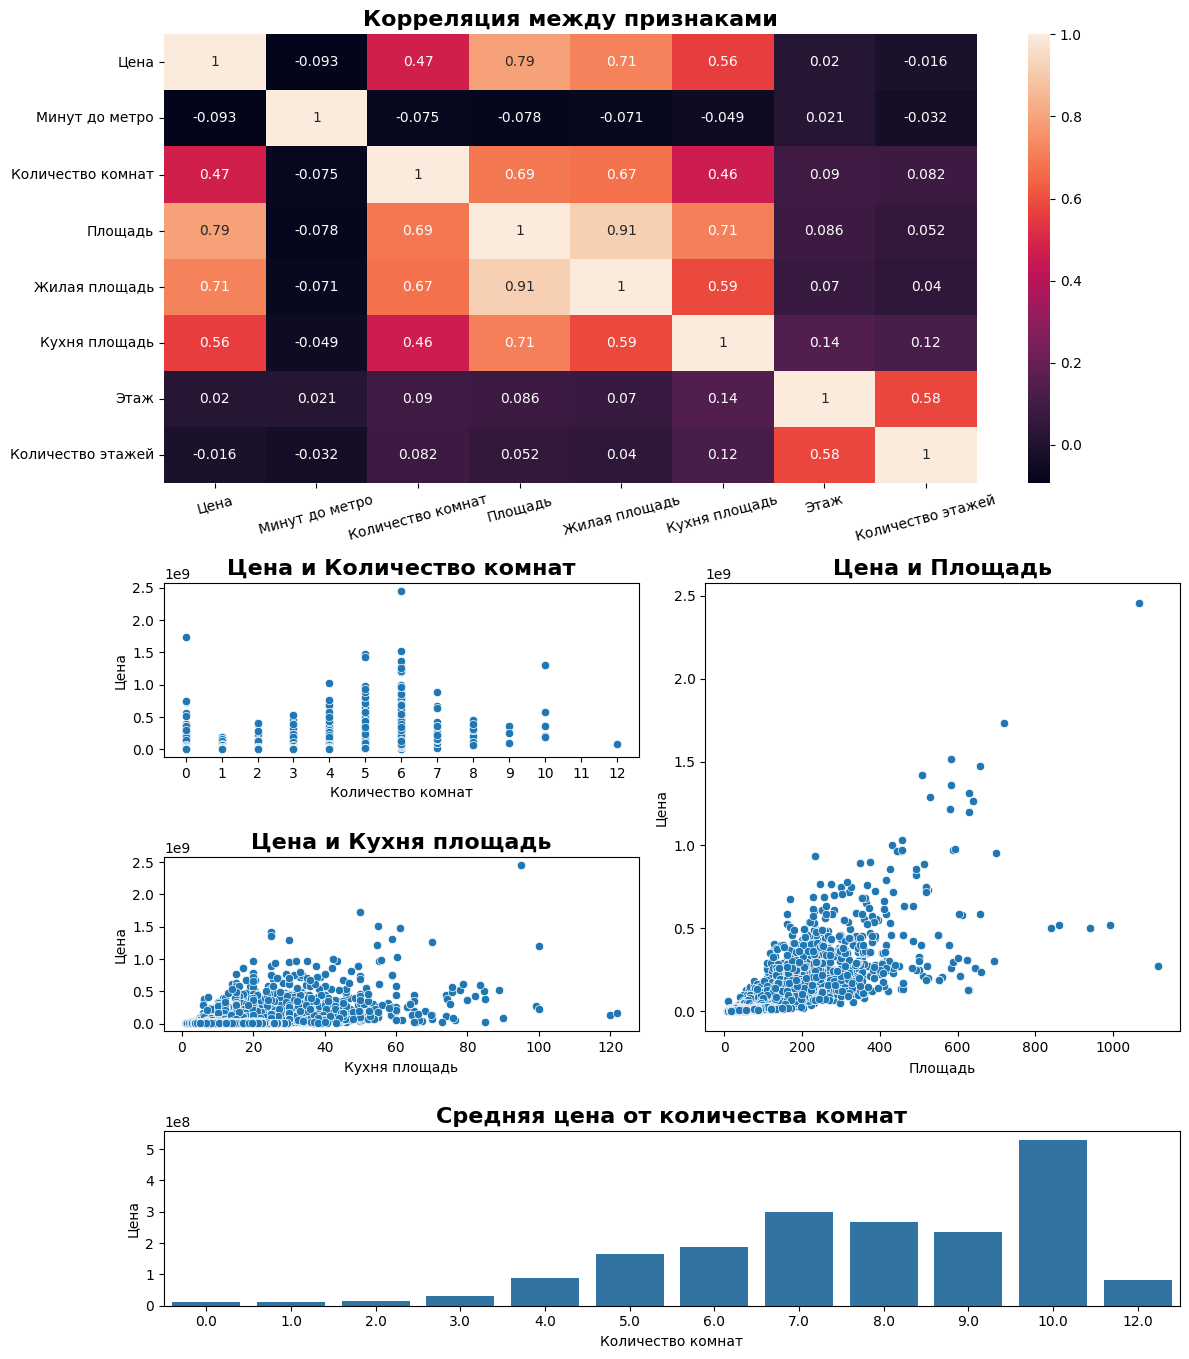

In [11]:
correlation = df.select_dtypes(include = ['float64', 'int64']).corr()

# Настроим размер общего холста (Figure)
fig = plt.figure(figsize=(12, 16))

# График 1 - Матрица корреляции для всех признаков 
ax1 = plt.subplot2grid((6, 2), (0, 0), rowspan = 2, colspan = 2)
sns.heatmap(correlation, annot = True, ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15) # Поворот меток на оси x
ax1.set_title('Корреляция между признаками')


# График 2 - Взаимосвязь между ценой и количеством комнат
ax2 = plt.subplot2grid((6, 2), (2, 0))
sns.scatterplot(data = df,
                x = 'Количество комнат',
                y = 'Цена',
                ax = ax2)
ax2.set_xticks(range(0,13,1))
ax2.set_title('Цена и Количество комнат')


# График 3 - Взаимосвязь между ценой и площадью
ax3 = plt.subplot2grid((6, 2), (2, 1), rowspan = 2)
sns.scatterplot(data = df,
                x = 'Площадь',
                y = 'Цена',
                ax = ax3)
ax3.set_title('Цена и Площадь')


# График 4 - Взаимосвязь между ценой и площадью кухни
ax4 = plt.subplot2grid((6, 2), (3, 0))
sns.scatterplot(data = df,
                x = 'Кухня площадь',
                y = 'Цена',
                ax = ax4)
ax4.set_title('Цена и Кухня площадь')


# График 5 - Средние значения цены в зависимости от количества комнат
ax5 = plt.subplot2grid((6, 2), (4, 0), rowspan = 1, colspan = 2)
price = df.groupby('Количество комнат').agg({'Цена' : 'mean'})
sns.barplot(data = price,
            x = price.index,
            y = price['Цена'],
            ax = ax5)
ax5.set_title('Средняя цена от количества комнат')

# Визуализация взаимосвязи между предикторами и целевой переменной
# ==============================================================================
plt.tight_layout()
plt.show()

**Вывод по визуализации взаимосвязей переменных:**
-
**Матрица корреляции**
1. Существует линейная зависимость между `Цена` (целевая переменная) и следующими признаками:
   -  `Количество комнат`
   -  `Площадь`
   -  `Жилая площадь`
   -  `Кухня площадь`
2. Существует мультиколлинеарность между признаками `Жилая площадь` и `Площадь`
Так как среди данных переменных наблюдается мультиколлинеарность (то есть сильная корреляция между предикторами), то удалим менее значимый признак (у которго меньше корреляция с целевой переменной - в данном случае - `Жилая площадь`
3. Так же сильная корреляция наблюдается между другими признаками
Нарпример `Площадь` - линейно зависима от таких признаков как `Количество комнат` и `Кухня площадь`
Или `Площадь кухни` линейно зависима так же от `Количество комнат`

То есть из этой информации делаем вывод, что чем больше комнат - тем больше площадь квартиры и соответственно тем больше цена квартиры (это только один из выводов, которые можно сделать)

**Точесные диаграммы**
Показывают взаимосвять признаков с целевой переменной (только те признаки, которые сильно коррелируют с целевой переменной `Цена`)
Здесь я построил 3 точечные диаграммы, так как сильная корреляци наблюдается только между целевой переменной и тремя предикторами

**Средняя цена от количества комнат**
График который показывает как количество комнат влияет на срденюю цену квартиры (это также показывает взаимосвязь между признаком `Количество комнат` и `Цена`
1. Цена квартиры растет с увеличением комнат до 7 комнат -> дальше цена падает (на это могут влиять внешние факторы, которые не учитывались при построении модели) -> наибольшая средняя цена за квартиру - 10 комнат -> цена падает на 12 комнатах, так как на это могут влиять так же другие внушние факторы, которые не были учтены

**Вывод**
После просмотра и анализа данной визуализации:
1. Определили признаки, которые взаимосвязаны с целевой переменной  (`Цена`)
2. Определили признак, который надо удалить из за наличия мультиколлинеарности (`Жилая площадь`)
3. Визализировали взаимосвязи между признаками и целемой переменной

Далее удалим признак `Жилая площадь` и просмотрим промежуточный наборы данных

In [12]:
df.drop('Жилая площадь', axis = 1, inplace = True)
print('Размер набора данных: ', df.shape)
df.head(3)

Размер набора данных:  (21813, 13)


,Цена,Тип квартиры,Станция метро,Минут до метро,Регион,Адрес,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Ремонт,Ссылка
0,6300000.0,Вторичное,Опалиха,6.0,Московская область,Московская Красногорский район Красногорск Изу...,1.0,30.6,8.5,25.0,25,Косметический,https://www.cian.ru/sale/flat/289238903
1,9000000.0,Вторичное,Павшино,2.0,Московская область,Московская Красногорский район Красногорск Иль...,1.0,49.2,10.0,6.0,15,Евроремонт,https://www.cian.ru/sale/flat/292849723
2,11090000.0,Вторичное,Мякинино,14.0,Московская область,Московская Красногорский район Красногорск бул...,1.0,44.7,13.1,10.0,25,Косметический,https://www.cian.ru/sale/flat/290714580


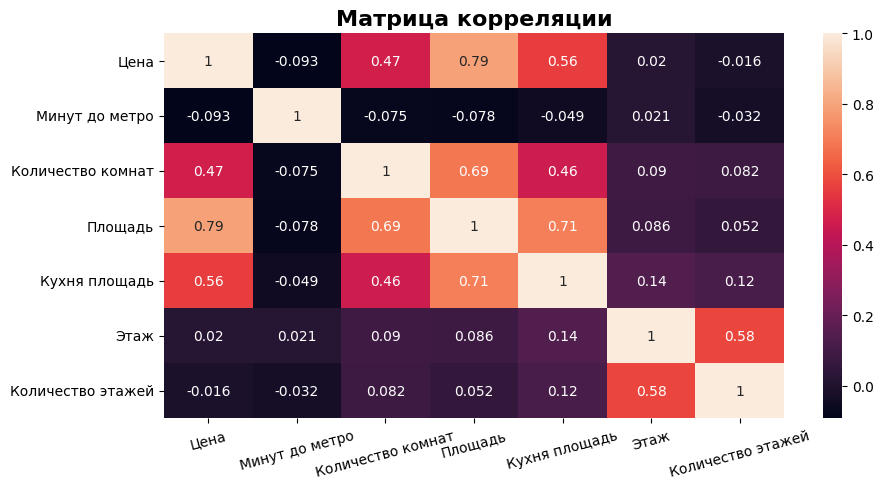

In [13]:
plt.subplots(figsize = (10,5))
correlation = df.select_dtypes(include = ['float64', 'int64']).corr()
sns.heatmap(correlation, annot = True)
plt.title('Матрица корреляции')
plt.xticks(rotation = 15)
plt.show()

## LinearRegression - Модель в MLFlow Tracking

### Ячейки не запускать

В качестве первой модели, построим модель линейной регрессии, которая будет включать в себя такие признаки, как 

`Цена` - целевая переменная 

Объясняющие переменные:
`Количество комнат`, `Площадь` и `Кухня площадь`  

Оценим эту модель на производительность и внесем ее в Tracking моделей в MLFlow для последующего сравнения с другими моделями, которые будут строиться дальше

In [14]:
# Разделеяем набор данных на целевую переменную и предикторы
y = df['Цена']
X = df[['Количество комнат', 'Площадь', 'Кухня площадь']]

# Строим модель линейной регресси на полном наборе данных
X = sm.add_constant(X)
linear_model = sm.OLS(y,X) # Метод наименьших квадратов
result = linear_model.fit() # Тренировка модели

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                 1.272e+04
Date:                Wed, 22 Nov 2023   Prob (F-statistic):               0.00
Time:                        00:24:09   Log-Likelihood:            -4.1631e+05
No. Observations:               21813   AIC:                         8.326e+05
Df Residuals:                   21809   BIC:                         8.327e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.715e+07   6.86e+0

После построения модели, признак `Кухня площадь` - оказался незначимым, поэтому удалим его и снова построим модель линейной регрессии и оценим результат с помощью модели `LineraRegression` в **sklearn**

In [15]:
y = df['Цена']
# Удалили признак 'Кухня площадь'
X = df[['Количество комнат', 'Площадь']]

# Строим модель линейной регресси на полном наборе данных
X = sm.add_constant(X)
linear_model = sm.OLS(y,X) # Метод наименьших квадратов
result = linear_model.fit() # Тренировка модели

# Вывод рузельтатов тренировки модели линейной регрессии
# ==============================================================================
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                 1.908e+04
Date:                Wed, 22 Nov 2023   Prob (F-statistic):               0.00
Time:                        00:24:10   Log-Likelihood:            -4.1631e+05
No. Observations:               21813   AIC:                         8.326e+05
Df Residuals:                   21810   BIC:                         8.327e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.783e+07   5.43e+0

In [16]:
params = result.params.to_frame()
params.columns = ['Веса модели']
params['Веса модели'] = params['Веса модели'].apply(lambda x: '{:.2f}'.format(x))

# Вывод параметров (весом) модели линейной регрессии
# ==============================================================================
params

,Веса модели
const,-27825303.75
Количество комнат,-7419286.54
Площадь,1099819.22


После удаления признака, качетсво модели (по критерию R2) никак не ухудшилось, поэтому протестируем модель с помощью sklern

In [17]:
# Раздибаем данные на тестовые и тренировочные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 10)

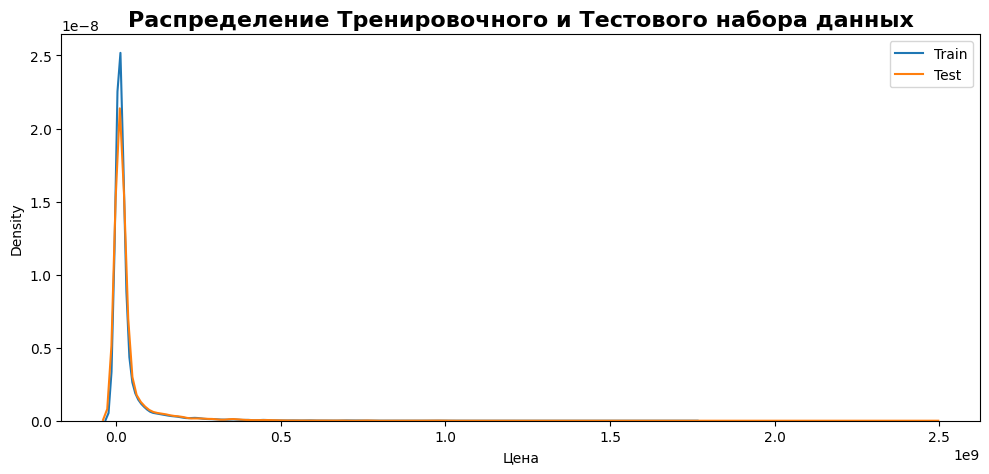

In [18]:
plt.subplots(figsize = (10,5))
# Смотрим распределение тестового и тренировочного набора данных (по цуелевой переменной)
sns.kdeplot(y_train, label = 'Train')
sns.kdeplot(y_test, label = 'Test')

plt.title('Распределение Тренировочного и Тестового набора данных')
plt.legend()
plt.tight_layout()
plt.show()

Данное распределение тренировочного и тестового набора данных выбрано именно это, потому что тренировочный и тестовых набор похожи по количеству информации о ценах, которые они представляют

Что имеется под количеством информации о ценам, на данном график:

То есть плотность значений опеределенной цены в одном наборе данных = плотности этой же цены в другом наборе данных, поэтому можно натренировать модель на данных, а потом протестировать их на похожих данных и оценить производительность модели

In [19]:
# Тренируем модель линейной регрессии 
# ==============================================================================
lr = LinearRegression()
lr.fit(X_train, y_train)

# Предсказание 
# ==============================================================================
y_pred = lr.predict(X_test)

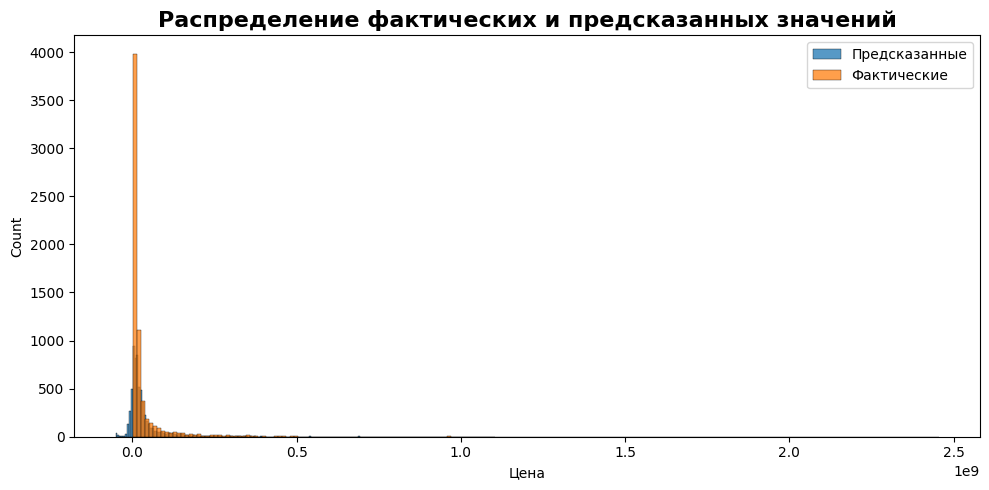

In [20]:
plt.subplots(figsize = (10,5))
sns.histplot(y_pred, bins = 200, label = 'Предсказанные')
sns.histplot(y_test, bins = 200, label = 'Фактические')

plt.title('Распределение фактических и предсказанных значений')
plt.legend()
plt.tight_layout()
plt.savefig('Распределение фактических и предсказанных значений.png')
plt.show()

Данное распределение между предсказанными значениями и фактическими значениями нужно, чтобы понять как распределяется цена на предсказанных значениях. 

По графику видно, что модель занижает значения цен, и есть значения, которые модель предсказала неправильно, совсем отклонившись от данных (синяя область слева), после мы оценим метрики модели, но уже сейчас можно сделать вывод, что можно протестирорвать вариант с регулязацией модели и попробовать в использовании L2 (Ridge) Регулязацию, после чего так же добавить ее к сравнению моделей

In [21]:
# Оценим метрики производительности модели линейной регрессии
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
mape = mean_absolute_percentage_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

# Метрики модели линейной регресии 
# ==============================================================================
print('mae: ', round(mae,2))
print('mse: ', round(mse,2))
print('mape: ', round(mape,2), '%')
print('r2: ', round(r2,2))

mae:  19516723.74
mse:  2438073690852249.0
mape:  1.74 %
r2:  0.41


Выводы по метрикам модели
-
**Средняя абсолютная ошибка** - 19 516 723.74, то есть в среднем модель ошибается на это число, что является очень большим отклонением в цене
**Среде квадратическая ошибка** - 2 438 073 690 852 249 - очень плохая метрика модели, так как данная метрика (MSE) очень чувтсвительна к большим отклоениям, следовательно можно сделать вывод, что модель плохо предсказывает информацию на новых данных
**Средне процентная ошибка** - модель в среднем ошибается на 1.74%, в целом это казалось бы не такой большой показатель, но учитывая суммы, на которые покупаются квартиры, это очень существенная цена, поэтому данный показатель тоже считается плохим
**Коэффициент детерминации** - модель объясняет только 41% в данных, что тоже является маленьким процентом, так как большая часть данных (59%) объясняется другими признаками и другими являениями

Из всего этого можно сделать вывод, данная модель плохо справляется с предсказаниями, но будет являться базовой моделью, чтобы увеличивать метрики

Далее будет построена Ridge регрессия, чтобы оценить работу данной модели и сделать регулязацию в данных

Зарегистрируем модель и метрики в MLFlow для контроля версий моделей

### Сохраняем данные для LinearRegression

In [22]:
# Сохранение полного набора данных для Линейной регрессии
X['Цена'] = y
X.to_csv('Данные для LinearRegression.csv')

### Сохранение в MLFlow

In [23]:
# Загрузка метрик и модели в MLFlow
# ==============================================================================

mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Создаем или получаем эксперимент
mlflow.set_experiment("House_price_predictions")

# Метрики для логирования
mae = round(mae,2)
mse = round(mse,2)
mape = round(mape,2)
r2 = round(r2,2)

signature = infer_signature(X_test, y_pred)

model_name = "Linear_Regression"
with mlflow.start_run(run_name = model_name) as run:
    
    # Логирование параметров
    mlflow.log_param("coef", lr.coef_)
    mlflow.log_param("intercept", lr.intercept_)

    # Логирование метрик
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mape", mape)
    mlflow.log_metric("r2_score", r2)


    # Логирование датасета как артефакта
    mlflow.log_artifact("Данные для LinearRegression.csv", artifact_path='data')
    mlflow.log_artifact("Распределение фактических и предсказанных значений.png", artifact_path='figures')
    
    # Запись модели
    mlflow.sklearn.log_model(lr, "linear_regression_model", signature=signature)

2023/11/22 00:24:21 INFO mlflow.tracking.fluent: Experiment with name 'House_price_predictions' does not exist. Creating a new experiment.


## Ridge Regression

Принцип работы модели остается такой же как и y `LinearRegression`, только добавляется штраф, за большие значения коэффициентов, это значит, что линия регрессии, которую будет искать модель (то есть линейную комбинаицию признаков, на которых мы обучаем модель) будет иметь более пологий наклон (в силу штрафа) и соответственно модель может лучше сработать на тестовом наборе данных (это мы и собираемся проверить, будет улучшение или нет)

**Какие данные используем для построения модели**:
Для модели Ride регрессии будем использовать вес данные, у которых тип данных - числовой, далее по значимости определим какие признаки лучше оставить и определим коэффициент регулизации, при помощи подбора гиперпарамтров модели по сетке (`GridSearch`)

### Тренировка модели Ridge регрессии (L2)

Сначала рпи помощи обычной линейной регрессии оценим значимость признаков (так как будем тренировать на всех данных), то есть произведем отбор признаков, по значению p-value, то есть чтобы все коэффициенты были значимы

In [24]:
X = df.select_dtypes(include = ['float64', 'int64']).drop('Цена', axis = 1)
y = df['Цена']

X = sm.add_constant(X)
ridge = sm.OLS(y,X)
results = ridge.fit()

# Вывод важности признаков
# ==============================================================================
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     6472.
Date:                Wed, 22 Nov 2023   Prob (F-statistic):               0.00
Time:                        00:24:27   Log-Likelihood:            -4.1619e+05
No. Observations:               21813   AIC:                         8.324e+05
Df Residuals:                   21806   BIC:                         8.324e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.545e+07   1.06e+0

В данной модели не значим признак `Кухня площадь` - так как значение p-value = 0.836, следовательно исключим этот признак и снова натренируем модель на новых данных, и очценим влияние признаков на целевую переменную 

In [25]:
X.drop('Кухня площадь', axis = 1, inplace = True)

ridge = sm.OLS(y,X)
results = ridge.fit()

# Вывод важности признаков
# ==============================================================================
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     7767.
Date:                Wed, 22 Nov 2023   Prob (F-statistic):               0.00
Time:                        00:24:27   Log-Likelihood:            -4.1619e+05
No. Observations:               21813   AIC:                         8.324e+05
Df Residuals:                   21807   BIC:                         8.324e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.538e+07      1e+0

Теперь все коэффициенты модели значимы, приступим к построению модели Ridge регрессии с помощью библиотеки **sklearn**

In [26]:
# Выбрали объясняющие переменные и целевую переменную, которую будем предсказывать
X = df.select_dtypes(include = ['float64', 'int64']).drop(['Цена', 'Кухня площадь'], axis = 1)
# Целевая переменная, которую будем предсказвыать
y = df['Цена']

# Разделим набор на тестовый и тренировочный
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 10)

In [27]:
# Натренируем модель сначала с коэффициентом регулязации 1, а потом переберем остальные параметры для оценки модели
ridge = Ridge(alpha = 1.0)

# Тренировка модели Ridge 
# ==============================================================================
ridge.fit(X_train,y_train)

Ridge()

### Оценка коэффициентов модели 

In [28]:
# Коэффициенты модели
coef = pd.DataFrame()
coef.index  = list(X.columns) 
coef['Коэффициенты'] = ridge.coef_
coef['Коэффициенты'] = coef['Коэффициенты'].apply(lambda x: '{:.2f}'.format(x))

# Значение свободного члена 
intercept = round(ridge.intercept_,2)


# Вывод коэффициентов модели
# ==============================================================================
print('Коэффициенты Ridge регрессии:')
print(coef)
print('\nСвободный член:', intercept)

Коэффициенты Ridge регрессии:
                  Коэффициенты
Минут до метро      -399145.73
Количество комнат  -7178390.68
Площадь             1100218.46
Этаж                -226717.28
Количество этажей   -331473.60

Свободный член: -15967253.01


In [29]:
y_pred = ridge.predict(X_test)

# Оценка метрик для Ridge
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
mape = mean_absolute_percentage_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

# Метрики модели 
# ==============================================================================
print('mae: ', round(mae,2))
print('mse: ', round(mse,2))
print('mape: ', round(mape,2), '%')
print('r2: ', round(r2,2))

mae:  19819176.14
mse:  2411139242079698.5
mape:  4.34 %
r2:  0.42


Модель хоть и стала описывать больший процент дисперсии, но метрики модели в целом стали хуже. Модель стала ошибаться на еще больший процент значений (4.34%), что является  большим числом относительно сумм за дома

1. Занесем модель в MLFlow Tracking
2. Подберем гиперпараметр (alpha) для ridge регрессии и оценим результат работы

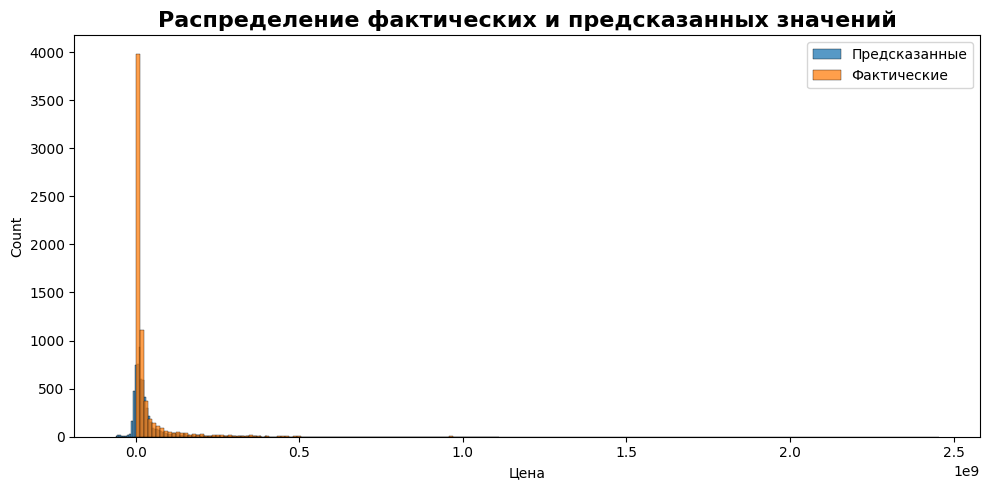

In [30]:
plt.subplots(figsize = (10,5))
sns.histplot(y_pred, bins = 200, label = 'Предсказанные')
sns.histplot(y_test, bins = 200, label = 'Фактические')

plt.title('Распределение фактических и предсказанных значений')
plt.legend()
plt.tight_layout()
plt.savefig('Распределение фактических и предсказанных значений.png')
plt.show()

### Занесем модель в MLFlow Tracking

In [31]:
X['Цена'] = y
X.to_csv('Данные для Ridge.csv')

# Загрузка метрик и модели в MLFlow
# ==============================================================================

mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Создаем или получаем эксперимент
mlflow.set_experiment("House_price_predictions")

# Метрики для логирования
mae = round(mae,2)
mse = round(mse,2)
mape = round(mape,2)
r2 = round(r2,2)

signature = infer_signature(X_test, y_pred)

model_name = "Ridge"
with mlflow.start_run(run_name = model_name) as run:
    
    # Логирование параметров
    mlflow.log_param("coef", ridge.coef_)
    mlflow.log_param("intercept", round(ridge.intercept_,2))

    # Логирование метрик
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mape", mape)
    mlflow.log_metric("r2_score", r2)


    # Логирование датасета как артефакта
    mlflow.log_artifact("Данные для Ridge.csv", artifact_path='data')
    mlflow.log_artifact("Распределение фактических и предсказанных значений.png", artifact_path='figures')
    
    # Запись модели
    mlflow.sklearn.log_model(lr, "Redge_model", signature=signature)

## Тюнинг Ridge регрессии

Теперь подберем гиперпараметры с помощью GridSearch и попробоуем улучшить метрику MAE

In [32]:
X = X.drop('Цена', axis = 1)

In [33]:
# создаем модель Ridge
ridge = Ridge()

# Метрика MAE
mae = make_scorer(mean_absolute_error, greater_is_better=False)

param = {'alpha' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]}
grid_search = GridSearchCV(ridge, param, scoring = mae, cv = 5)

# Выполним поиск по сетке
# ==============================================================================
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
                                   1.9, 2.0]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [34]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка MAE:", -grid_search.best_score_)

Лучшие параметры: {'alpha': 0.1}
Лучшая оценка MAE: 20857124.83518904


После подбора гиперпараметров на крос валидации, лучшим параметром оказалось значение `alpha` =  0.1
Натренируем модель с этим гиперпараметром и запишем ее в MLFlow Tracking

In [35]:
ridge = Ridge(alpha = 0.1)

ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [36]:
y_pred = ridge.predict(X_test)

# Оценка метрик для Ridge
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
mape = mean_absolute_percentage_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

# Метрики модели 
# ==============================================================================
print('mae: ', round(mae,2))
print('mse: ', round(mse,2))
print('mape: ', round(mape,2), '%')
print('r2: ', round(r2,2))

mae:  19819097.36
mse:  2411139062655098.0
mape:  4.17 %
r2:  0.42


Модель стала лучше работать, чем Ridge без гиперпараметров, но все равно модель показывает плохие результаты, поэтому просто запишем ее в MLFlow Tracking и продолжим тестировать модели дальше 

### Записть Ridge hyperparameters в MLFlow

In [37]:
X['Цена'] = y
X.to_csv('Данные для Ridge_hyperparameters.csv')

# Загрузка метрик и модели в MLFlow
# ==============================================================================

mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Создаем или получаем эксперимент
mlflow.set_experiment("House_price_predictions")

# Метрики для логирования
mae = round(mae,2)
mse = round(mse,2)
mape = round(mape,2)
r2 = round(r2,2)

signature = infer_signature(X_test, y_pred)

model_name = "Ridge_hyperparameters"
with mlflow.start_run(run_name = model_name) as run:
    
    # Логирование параметров
    mlflow.log_param("coef", ridge.coef_)
    mlflow.log_param("intercept", round(ridge.intercept_,2))

    # Логирование метрик
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mape", mape)
    mlflow.log_metric("r2_score", r2)


    # Логирование датасета как артефакта
    mlflow.log_artifact("Данные для Ridge_hyperparameters.csv", artifact_path='data')
    
    # Запись модели
    mlflow.sklearn.log_model(lr, "Redge_hyperparameters", signature=signature)

## RandomForest на числовых признаках

Это будет последняя модель, которую мы построим только на числовых признаках. Мы натренируем базовую модель случайного леса, после чего подберем гиперпараметры и всю информацию о моделях запишем в MLFlow Tracking, чтобы было после легко визуально сравнивать и оценивать производительность моделей. 

Данные будем использовать теже, что и при тренировки модели Ridge (то есть только числовые признаки)

In [38]:
X.drop('Цена', axis = 1, inplace = True)

In [39]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

### Оценка важности признаков модели RandomForest

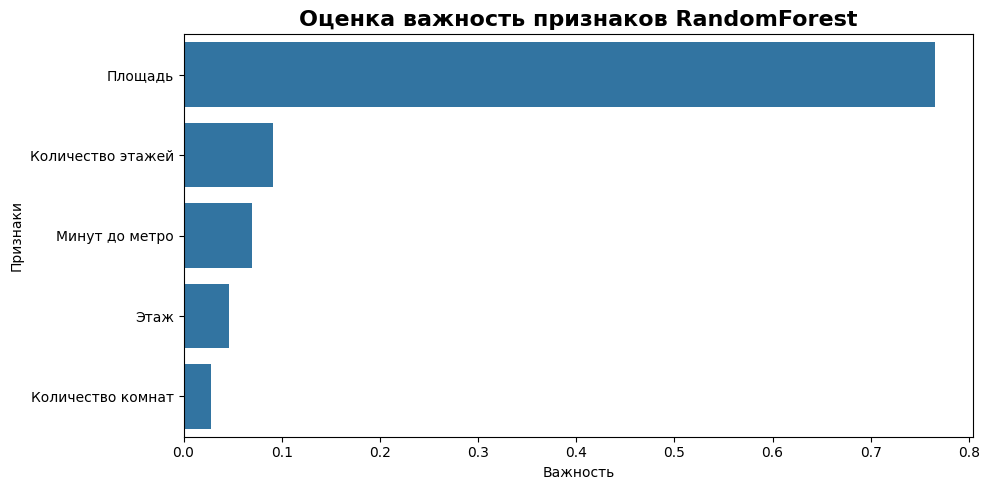

In [40]:
feature_importance = rf.feature_importances_
feature_names = X_train.columns

importance = pd.DataFrame()
importance.index = feature_names
importance['Важность'] = feature_importance
importance = importance.sort_values(by = 'Важность', ascending = False)

fig1 = plt.subplots(figsize = (10,5))
sns.barplot(data = importance,
            y = importance.index,
            x = 'Важность')

plt.ylabel('Признаки')
plt.title('Оценка важность признаков RandomForest')
plt.savefig("Оценка важность признаков RandomForest.png")
plt.tight_layout()
plt.show()

Данный график показывает важность признаков, при тренировки модели `RandomForest`

**Выводы по важности признаков**
1. Самым важным признаком, при обучении модели - Площадь
2. Признаки (кроме площади) сильно отстают в важности, но все таки используются в модели, поэтому их следует оставить
3. Признак, который меньше всего использовался при разбиениях - `Количество комнат`

### Оценим производительность модели RandomForest с помощью метрик

In [41]:
y_pred = rf.predict(X_test)

# Оценка метрик для RandomForest
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
mape = mean_absolute_percentage_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

# Метрики модели RandomForest
# ==============================================================================
print('mae: ', round(mae,2))
print('mse: ', round(mse,2))
print('mape: ', round(mape,2), '%')
print('r2: ', round(r2,2))

mae:  10410917.37
mse:  1739535981589424.0
mape:  0.19 %
r2:  0.65


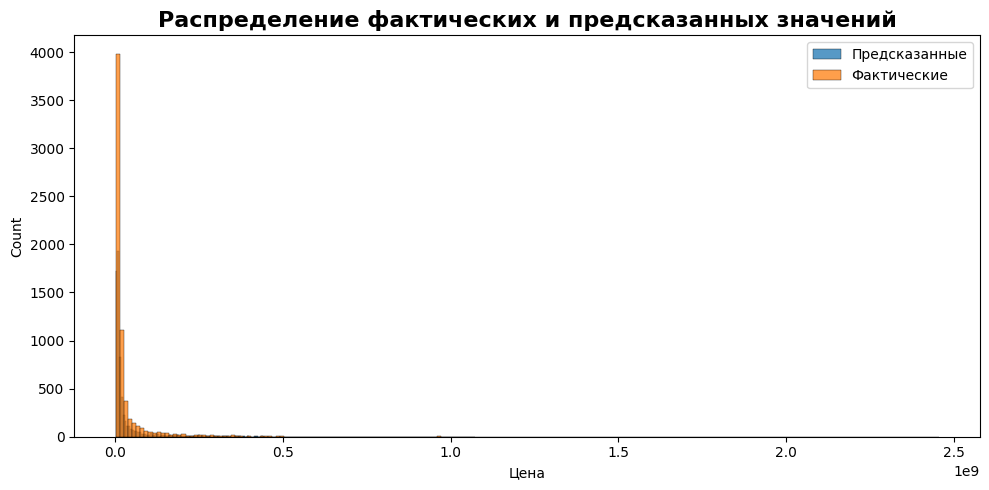

In [42]:
fig2 = plt.subplots(figsize = (10,5))
sns.histplot(y_pred, bins = 200, label = 'Предсказанные')
sns.histplot(y_test, bins = 200, label = 'Фактические')

plt.title('Распределение фактических и предсказанных значений')
plt.legend()
plt.tight_layout()
plt.savefig("Распределение фактических и предсказанных значений.png")
plt.show()

1. Данная модель обобщает большую чать дисперсии - 64%
2. Модель имеет ошибку всего в 0.19%, что является улучшением BaseLine
3. По графику видно, что плотности распределений предсказанных значений и фактических значений лучше совпадают, чем на предыдущих моделях

Запишем результаты работы модели в MLFlow Tracking

### Запись RandomForest в MLFlow Tracking

In [43]:
X['Цена'] = y
X.to_csv('Данные для RandomForest_numeric.csv')

# Загрузка метрик и модели в MLFlow
# ==============================================================================
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Создаем или получаем эксперимент
mlflow.set_experiment("House_price_predictions")

# Метрики для логирования
mae = round(mae,2)
mse = round(mse,2)
mape = round(mape,2)
r2 = round(r2,2)

signature = infer_signature(X_test, y_pred)

model_name = "RandomForest_numeric"
with mlflow.start_run(run_name = model_name) as run:
    
    # Логирование метрик
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mape", mape)
    mlflow.log_metric("r2_score", r2)


    # Логирование датасета как артефакта
    mlflow.log_artifact("Данные для RandomForest_numeric.csv", artifact_path='data')
    mlflow.log_artifact("Оценка важность признаков RandomForest.png", artifact_path='figures') 
    mlflow.log_artifact("Распределение фактических и предсказанных значений.png", artifact_path='figures')
    
    # Запись модели
    mlflow.sklearn.log_model(lr, "RandomForest_numeric", signature=signature)

### Задачи на завтра 

1. Подбор гиперпараметров RandomForest
2. Тренировка моделей с категориальными данными